In [1]:
import gcsfs #module for google cloud connection
import os
import allel
import zarr
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns

In [2]:
gcs_orig = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache')
gcs =  gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token=gcs_orig.session.credentials)

In [3]:
phase2path = os.path.join("ag1000g-release", "phase2.AR1", "variation", "main", "zarr", "biallelic", "ag1000g.phase2.ar1.pass.biallelic")

In [4]:
gcsmap = gcsfs.mapping.GCSMap(phase2path, gcs=gcs)

In [44]:
def abba_baba(chrom, a, b, c, d, windows_size):

    #loading metadata
    metadata = pd.read_csv("samples.meta.txt", sep="\t")
    pop_select = metadata.population.isin({a, b, c, d}).values
    pop_subset = metadata[pop_select]
    
    #loading genome and subset
    calldata= zarr.Group(gcsmap, read_only=True)
    g = calldata [chrom]["calldata/GT"]
    variants = calldata [chrom]["variants"]
    pos = variants['POS'][:]
    geno = allel.GenotypeChunkedArray(g)
    geno_subset = geno.subset(sel1=pop_select)
    
    #count alleles
    grp = pop_subset.groupby("population")
    grp_indices = grp.indices
    ac_subpops = geno_subset.count_alleles_subpops(grp_indices)
    
    #perform abba baba test
    y = allel.average_patterson_d(ac_subpops[a], ac_subpops[b], ac_subpops[c], ac_subpops[d], windows_size)
    
    # compute windows with equal numbers of SNPs
    windows = allel.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], size=windows_size)
    x = np.asarray(windows).mean(axis=1)
    
    # Plot the test
    fig, ax = pyplot.subplots(figsize=(12, 4))
    #sns.despine(ax=ax, offset=10)
    ax.plot(x, y[3], lw=.5)
    ax.set_ylabel("D Value")
    ax.set_xlabel('Chromosome %s position (bp)' %chrom)
    ax.set_xlim(0, pos.max())
    ax.set_title(('ABBA BABA Test between %s, %s, %s, %s') % (a,b,c,d))


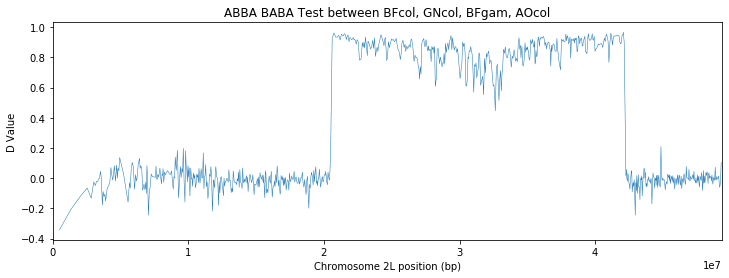

In [45]:
abba_baba('2L', 'BFcol', 'GNcol', 'BFgam', 'AOcol', 10000)